In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import h5py


# --- Load All PMT Data ---
pmts = [1, 2, 3, 9, 10, 12, 14, 17, 18, 19, 1021, 1118]
time = []
signal = []
trigger = []

for pmt in pmts:
    with h5py.File(f'C:/Users/Anwender/Documents/TUM/Masterarbeit/Programming/new_PMTs/pmt{pmt}.hdf5', 'r') as f:
        key = list(f.keys())[0]
        dset = f[key]
        time.append(dset['dataset'][:, :, 0])
        signal.append(dset['dataset'][:, :, 1])
        trigger.append(dset['dataset'][:, :, 3])

print("✅ All PMT data loaded.")


✅ All PMT data loaded.


In [9]:
from scipy.special import erf
from scipy.special import erfc
# --- Define Gaussian function ---
def gauss(x, N, mu, sigma):
    return (N / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (x - mu)**2 / (2 * sigma**2))

def skewed_gauss(x, N, mu, sigma, alpha):
    norm = N / (sigma * np.sqrt(2 * np.pi))
    gauss = np.exp(- (x - mu)**2 / (2 * sigma**2))
    skew = 1 + erf(alpha * (x - mu) / (np.sqrt(2) * sigma))
    return norm * gauss * skew

def emg(x, N, mu, sigma, lam):
    from scipy.special import erfc
    conv = lam / 2 * np.exp(lam / 2 * (2 * mu + lam * sigma**2 - 2 * x))
    tail = erfc((mu + lam * sigma**2 - x) / (np.sqrt(2) * sigma))
    return N * conv * tail

In [18]:

# --- Define Analysis and Plotting Function ---
def analyze_pmt(i, trigger_val=-100, t_min_range=(100, 130)):
    min_times = []
    n_waveforms = time[i].shape[0]
    bins=np.linspace(100,130,5000)
    
    for w in range(n_waveforms):
        trig = trigger[i][w]
        crossings = np.flatnonzero((trig[:-1] > trigger_val) & (trig[1:] < trigger_val))
        if crossings.size == 0:
            continue
        
        trigger_index = crossings[0]
        t = time[i][w] - time[i][w, trigger_index]
        s = signal[i][w]

        min_idx = np.argmin(s)
        t_min = t[min_idx]

        #if t_min_range[0] <= t_min <= t_min_range[1]:
        min_times.append(t_min)

    # --- Plot ---
    if len(min_times) >= 10:
        counts, bin_edges = np.histogram(min_times, bins=bins)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        #p0 = [np.max(counts), np.mean(min_times), np.std(min_times)]

        try:
            # Mask and fit data
            mask = np.ones(len(bins) - 1, dtype=bool) & (counts[:] != 0)
            x_fit = bins[:-1][mask] + np.diff(bins)[0]/2
            y_fit = counts[mask]

            popt, pcov = optimize.curve_fit(gauss,x_fit,y_fit,p0=[np.max(y_fit), np.max(x_fit), np.std(x_fit)])
            #popt, _ = optimize.curve_fit(gauss, bin_centers, counts, p0=p0)
            N_fit, mu_fit, sigma_fit = popt
            tts=2*np.sqrt(2*np.log(2))*sigma_fit
            tts_list.append(tts)
            x_fit = np.linspace(bin_centers[0], bin_centers[-1], 500)
            plt.plot(x_fit, gauss(x_fit, N_fit, mu_fit, sigma_fit), 'r-', label=f'Gauss fit\n$\mu$={mu_fit:.2f}, $\sigma$={sigma_fit:.2f}, TTS={tts:.2f}')
           
            #tried different gauss models
            '''
            # Initial guess: N, mu, sigma, lambda
            p0 = [np.max(y_fit), np.mean(x_fit), np.std(x_fit), 0.1]  # lam=0.1 is a small right tail

            # Fit with EMG
            popt, pcov = optimize.curve_fit(emg, x_fit, y_fit, p0=p0, maxfev=10000)
            N_fit, mu_fit, sigma_fit, lam_fit = popt

            #tts = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
            tts = 2.355*sigma_fit*np.sqrt(1+0.57*lam_fit*sigma_fit)
            tts_list.append(tts)

            # Plot the fit
            x_plot = np.linspace(bin_centers[0], bin_centers[-1], 500)
            plt.plot(x_plot, emg(x_plot, *popt), 'r-', label=f'EMG fit\nμ={mu_fit:.2f}, σ={sigma_fit:.2f}, λ={lam_fit:.3f}, TTS={tts:.2f}')

            #skewed gauss
            p0 = [np.max(y_fit), np.mean(x_fit), np.std(x_fit), 1.0]  # alpha = 1 is a decent skew guess

            # Fit with skewed Gaussian
            popt, pcov = optimize.curve_fit(skewed_gauss, x_fit, y_fit, p0=p0, maxfev=10000)
            N_fit, mu_fit, sigma_fit, alpha_fit = popt

            tts = 2 * np.sqrt(2 * np.log(2)) * sigma_fit
            tts_list.append(tts)

            # Plot the fit
            x_plot = np.linspace(bin_centers[0], bin_centers[-1], 500)
            plt.plot(x_plot, skewed_gauss(x_plot, *popt), 'r-', label=f'Skewed Gauss fit\nμ={mu_fit:.2f}, σ={sigma_fit:.2f}, α={alpha_fit:.2f}, TTS={tts:.2f}')
            '''
            



        except Exception as e:
            print(f"⚠️ Fit failed for PMT {pmts[i]}:", e)
            return

        plt.hist(min_times, bins=bins, histtype='step', label='Data')
        plt.xlabel("Time of signal minimum [ns]")
        plt.ylabel("Counts")
        plt.title(f"PMT {pmts[i]} — Histogram and Gaussian Fit")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"⚠️ Not enough valid minima for PMT {pmts[i]} (found {len(min_times)} values).")



<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anwender\AppData\Local\Temp\ipykernel_14752\2972096506.py:41: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x_fit, gauss(x_fit, N_fit, mu_fit, sigma_fit), 'r-', label=f'Gauss fit\n$\mu$={mu_fit:.2f}, $\sigma$={sigma_fit:.2f}, TTS={tts:.2f}')
C:\Users\Anwender\AppData\Local\Temp\ipykernel_14752\2972096506.py:41: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x_fit, gauss(x_fit, N_fit, mu_fit, sigma_fit), 'r-', label=f'Gauss fit\n$\mu$={mu_fit:.2f}, $\sigma$={sigma_fit:.2f}, TTS={tts:.2f}')



--- Analyzing PMT 1 (index 0) ---


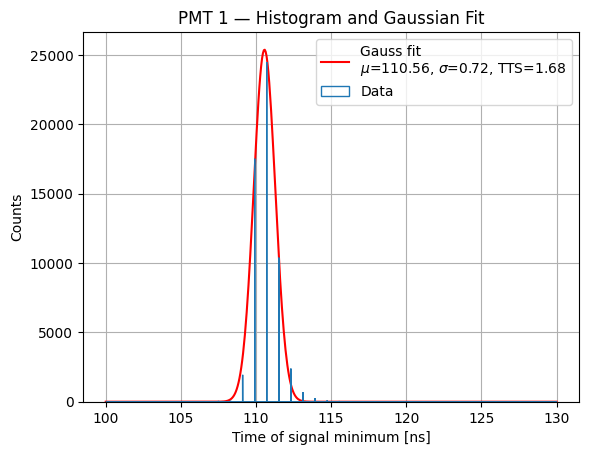


--- Analyzing PMT 2 (index 1) ---


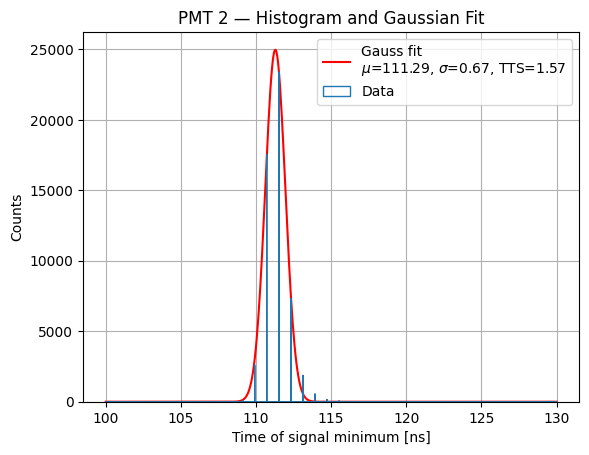


--- Analyzing PMT 3 (index 2) ---


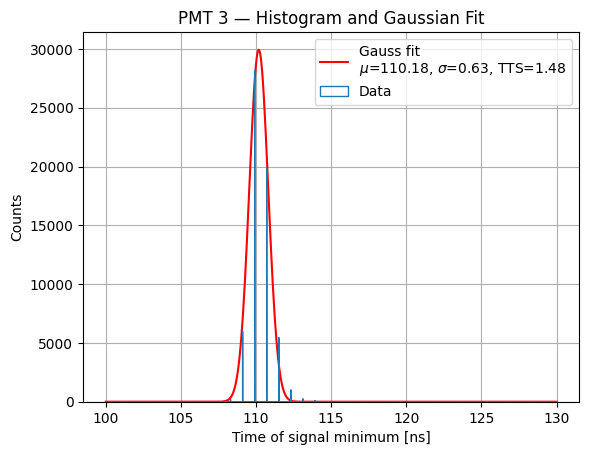


--- Analyzing PMT 9 (index 3) ---


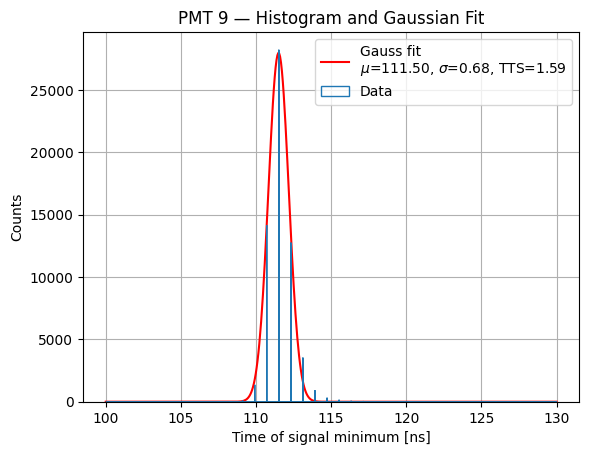


--- Analyzing PMT 10 (index 4) ---


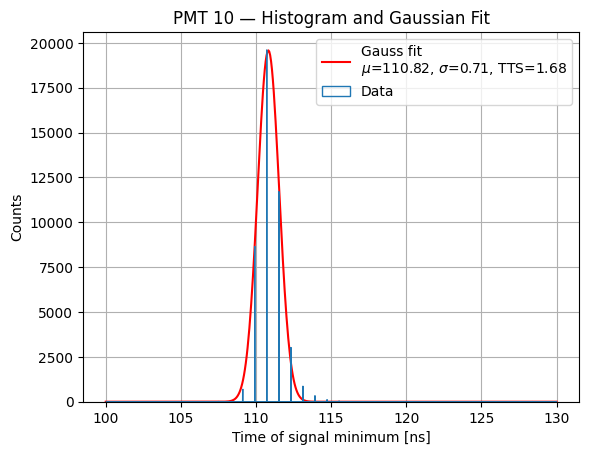


--- Analyzing PMT 12 (index 5) ---


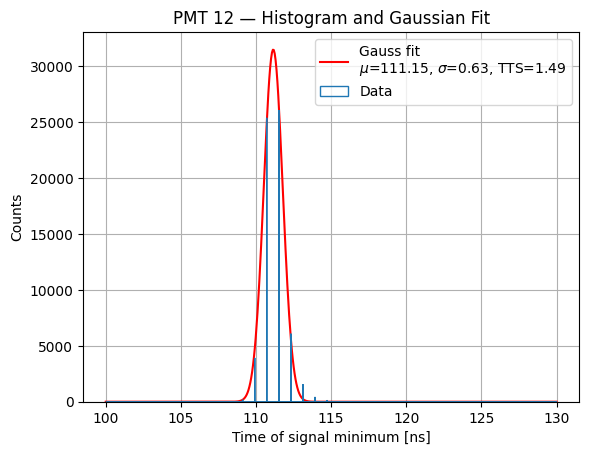


--- Analyzing PMT 14 (index 6) ---


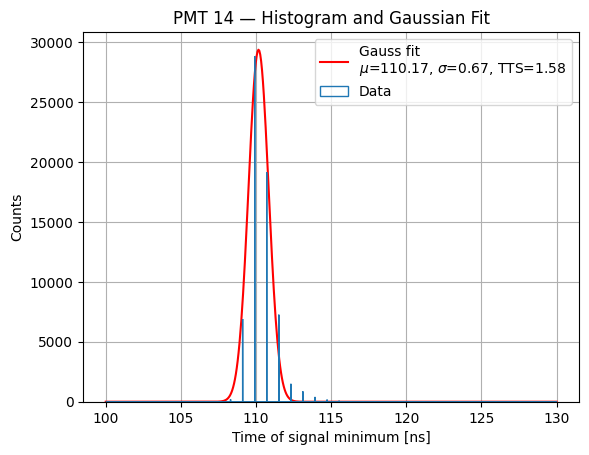


--- Analyzing PMT 17 (index 7) ---


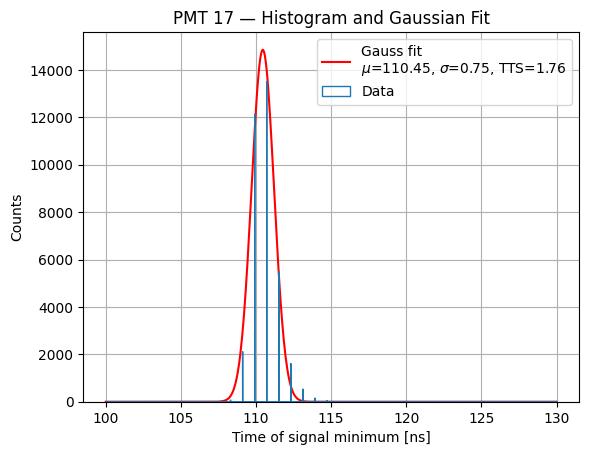


--- Analyzing PMT 18 (index 8) ---


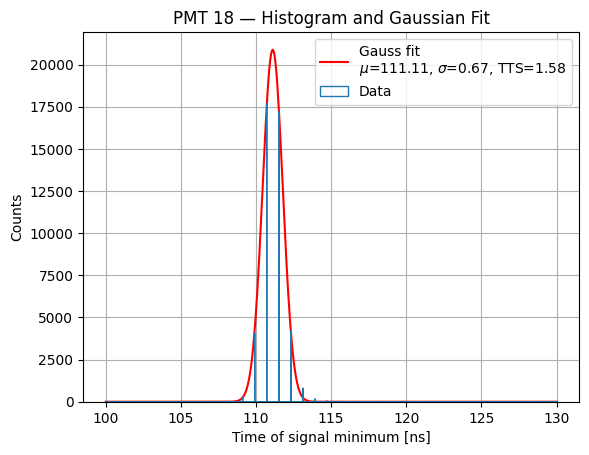


--- Analyzing PMT 19 (index 9) ---


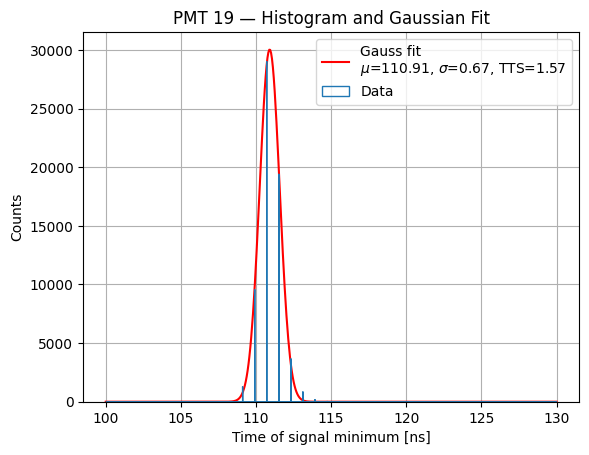


--- Analyzing PMT 1021 (index 10) ---


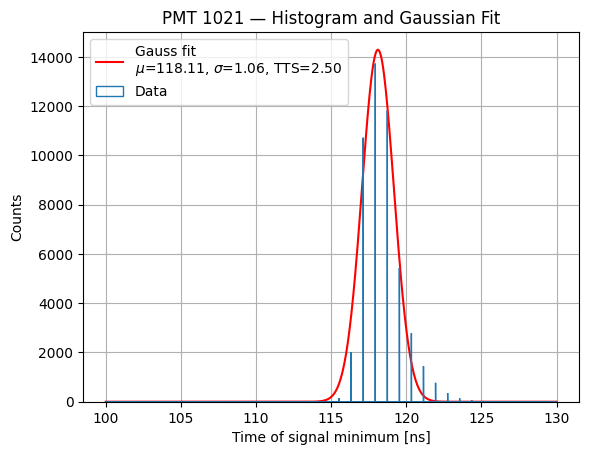


--- Analyzing PMT 1118 (index 11) ---


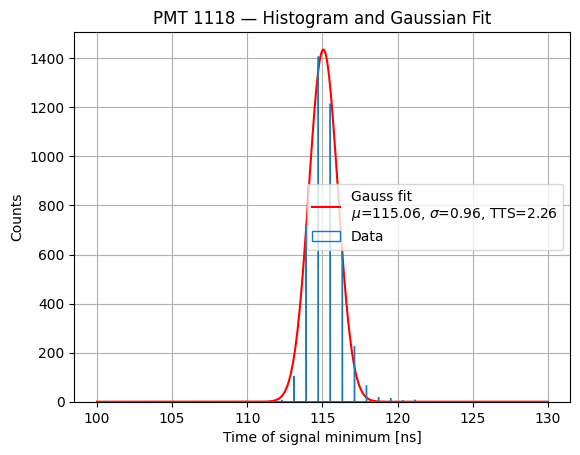

PMT 1: TTS = 1.68 ns
PMT 2: TTS = 1.57 ns
PMT 3: TTS = 1.48 ns
PMT 9: TTS = 1.59 ns
PMT 10: TTS = 1.68 ns
PMT 12: TTS = 1.49 ns
PMT 14: TTS = 1.58 ns
PMT 17: TTS = 1.76 ns
PMT 18: TTS = 1.58 ns
PMT 19: TTS = 1.57 ns
PMT 1021: TTS = 2.50 ns
PMT 1118: TTS = 2.26 ns


In [19]:
# --- Run Analysis for All PMTs ---
tts_list=[]
for i in range(len(pmts)):
    print(f"\n--- Analyzing PMT {pmts[i]} (index {i}) ---")
    analyze_pmt(i)
for i in range(len(pmts)):
    print(f"PMT {pmts[i]}: TTS = {tts_list[i]:.2f} ns")

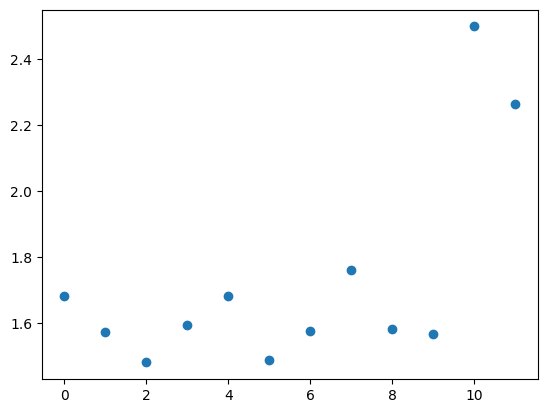

In [41]:
plt.plot(tts_list,marker="o", linestyle='None')